In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agent import Agent, SARSALambdaAgent
from environment import Environment
from screen import Screen

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


Configurações gerais para a execução dos modelos:

* O espaço de ações é denifido como uma matriz identidade 3x3
* Há três ações possíveis (continuar na mesma direção, virar para a esquerda, virar para a direita)
* Como cada estado é representado por um vetor binário de 11 posições, ao todo há 2^11 estados possíveis

In [2]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [3]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [4]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


A função de recompensa padrão é definida como:
    
* Ganha 10 pontos por comer a maçã
* Perde 10 pontos por morrer
* Recompensa 0 caso contrário

In [5]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

# SARSA

Seguiremos os mesmos experimentos realizados com o Q-Learning, de modo a verificarmos a diferença nos resultados variando apenas o agente.

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 2
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 4
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 5
Game 38      Score: 1
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 3
Game 42      Score: 1
Game 43      Score: 4
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

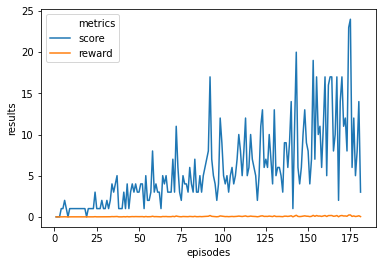

In [7]:
def run_sarsa(agent: SARSALambdaAgent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()
        agent.reset_E()
        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
        

    return metrics

N0 = 1
gamma = 1

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 0.5

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### lambda = 0

* N0 = 1
* gamma = 0.99
* número de episódios = 1000

Usando o melhor N0 e o melhor gamma do SARSA(0).

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 719      Score: 0
Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762   

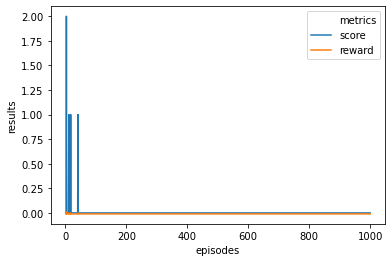

Run time: 234.9409098625183 seconds
Max. Score: 2
Mean Last Scores: 0.0


Foi muito ruim. Mas com lambda = 0 isso ia acontecer mesmo, por causa da forma que a gente implementou a função de update.

```
self.Q[prev_state, prev_action] += alpha * delta * self.E[s, a];
self.E[prev_state, prev_action] = self.gamma * self.lambda_value * self.E[s, a];
```

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405      Score: 0
Game 406   

Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762      Score: 0
Game 763   

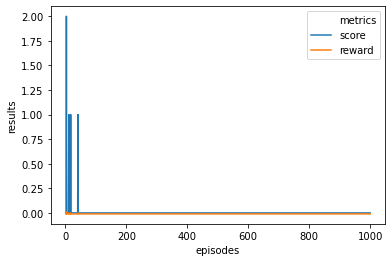

Run time: 229.86478328704834 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [9]:
N0 = 1
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 0.2

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 719      Score: 0
Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762   

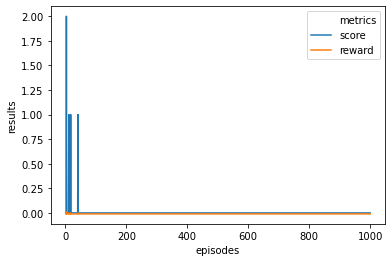

Run time: 229.7477252483368 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [10]:
N0 = 1
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 0.5

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762      Score: 0
Game 763   

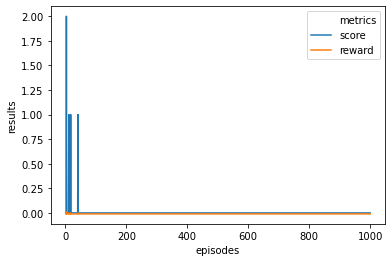

Run time: 226.54747486114502 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [11]:
N0 = 1
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 0.7

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 719      Score: 0
Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762   

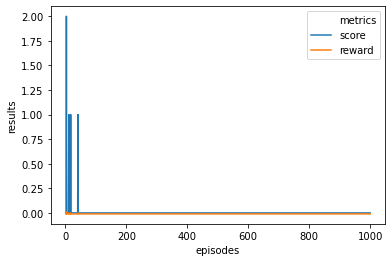

Run time: 230.0121157169342 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [12]:
N0 = 1
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 1

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 1
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 2
Game 20      Score: 1
Game 21      Score: 0
Game 22      Score: 1
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 719      Score: 0
Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762   

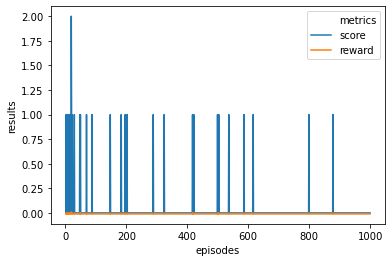

Run time: 242.16705989837646 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [13]:
N0 = 10
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 1

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 1
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 2
Game 20      Score: 1
Game 21      Score: 0
Game 22      Score: 1
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 362      Score: 0
Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405   

Game 719      Score: 0
Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762   

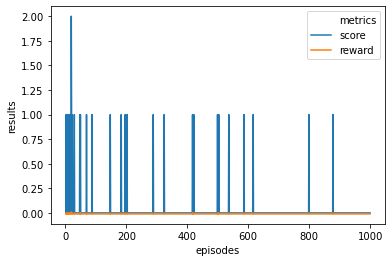

Run time: 235.16607880592346 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [14]:
N0 = 10
gamma = 0.5

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 1

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 1
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 2
Game 20      Score: 1
Game 21      Score: 0
Game 22      Score: 1
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 0
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 363      Score: 0
Game 364      Score: 0
Game 365      Score: 0
Game 366      Score: 0
Game 367      Score: 0
Game 368      Score: 0
Game 369      Score: 0
Game 370      Score: 0
Game 371      Score: 0
Game 372      Score: 0
Game 373      Score: 0
Game 374      Score: 0
Game 375      Score: 0
Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405      Score: 0
Game 406   

Game 720      Score: 0
Game 721      Score: 0
Game 722      Score: 0
Game 723      Score: 0
Game 724      Score: 0
Game 725      Score: 0
Game 726      Score: 0
Game 727      Score: 0
Game 728      Score: 0
Game 729      Score: 0
Game 730      Score: 0
Game 731      Score: 0
Game 732      Score: 0
Game 733      Score: 0
Game 734      Score: 0
Game 735      Score: 0
Game 736      Score: 0
Game 737      Score: 0
Game 738      Score: 0
Game 739      Score: 0
Game 740      Score: 0
Game 741      Score: 0
Game 742      Score: 0
Game 743      Score: 0
Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762      Score: 0
Game 763   

Game 1075      Score: 0
Game 1076      Score: 0
Game 1077      Score: 0
Game 1078      Score: 0
Game 1079      Score: 0
Game 1080      Score: 0
Game 1081      Score: 0
Game 1082      Score: 0
Game 1083      Score: 0
Game 1084      Score: 0
Game 1085      Score: 0
Game 1086      Score: 0
Game 1087      Score: 0
Game 1088      Score: 0
Game 1089      Score: 0
Game 1090      Score: 0
Game 1091      Score: 0
Game 1092      Score: 0
Game 1093      Score: 0
Game 1094      Score: 0
Game 1095      Score: 0
Game 1096      Score: 0
Game 1097      Score: 0
Game 1098      Score: 0
Game 1099      Score: 0
Game 1100      Score: 0
Game 1101      Score: 0
Game 1102      Score: 0
Game 1103      Score: 0
Game 1104      Score: 0
Game 1105      Score: 0
Game 1106      Score: 0
Game 1107      Score: 0
Game 1108      Score: 0
Game 1109      Score: 0
Game 1110      Score: 0
Game 1111      Score: 0
Game 1112      Score: 0
Game 1113      Score: 0
Game 1114      Score: 0
Game 1115      Score: 0
Game 1116      S

Game 1417      Score: 0
Game 1418      Score: 0
Game 1419      Score: 0
Game 1420      Score: 0
Game 1421      Score: 0
Game 1422      Score: 0
Game 1423      Score: 0
Game 1424      Score: 0
Game 1425      Score: 0
Game 1426      Score: 0
Game 1427      Score: 0
Game 1428      Score: 0
Game 1429      Score: 0
Game 1430      Score: 0
Game 1431      Score: 0
Game 1432      Score: 0
Game 1433      Score: 0
Game 1434      Score: 0
Game 1435      Score: 0
Game 1436      Score: 0
Game 1437      Score: 0
Game 1438      Score: 0
Game 1439      Score: 0
Game 1440      Score: 0
Game 1441      Score: 0
Game 1442      Score: 0
Game 1443      Score: 0
Game 1444      Score: 0
Game 1445      Score: 0
Game 1446      Score: 0
Game 1447      Score: 0
Game 1448      Score: 0
Game 1449      Score: 0
Game 1450      Score: 0
Game 1451      Score: 0
Game 1452      Score: 0
Game 1453      Score: 0
Game 1454      Score: 0
Game 1455      Score: 0
Game 1456      Score: 0
Game 1457      Score: 0
Game 1458      S

Game 1760      Score: 0
Game 1761      Score: 0
Game 1762      Score: 0
Game 1763      Score: 0
Game 1764      Score: 0
Game 1765      Score: 0
Game 1766      Score: 0
Game 1767      Score: 0
Game 1768      Score: 0
Game 1769      Score: 0
Game 1770      Score: 0
Game 1771      Score: 0
Game 1772      Score: 0
Game 1773      Score: 0
Game 1774      Score: 0
Game 1775      Score: 0
Game 1776      Score: 0
Game 1777      Score: 0
Game 1778      Score: 0
Game 1779      Score: 0
Game 1780      Score: 0
Game 1781      Score: 0
Game 1782      Score: 0
Game 1783      Score: 0
Game 1784      Score: 0
Game 1785      Score: 0
Game 1786      Score: 0
Game 1787      Score: 0
Game 1788      Score: 0
Game 1789      Score: 0
Game 1790      Score: 0
Game 1791      Score: 0
Game 1792      Score: 0
Game 1793      Score: 0
Game 1794      Score: 0
Game 1795      Score: 0
Game 1796      Score: 0
Game 1797      Score: 0
Game 1798      Score: 0
Game 1799      Score: 0
Game 1800      Score: 0
Game 1801      S

Game 2102      Score: 0
Game 2103      Score: 0
Game 2104      Score: 0
Game 2105      Score: 0
Game 2106      Score: 0
Game 2107      Score: 0
Game 2108      Score: 0
Game 2109      Score: 0
Game 2110      Score: 0
Game 2111      Score: 0
Game 2112      Score: 0
Game 2113      Score: 0
Game 2114      Score: 0
Game 2115      Score: 0
Game 2116      Score: 0
Game 2117      Score: 0
Game 2118      Score: 0
Game 2119      Score: 0
Game 2120      Score: 0
Game 2121      Score: 0
Game 2122      Score: 0
Game 2123      Score: 0
Game 2124      Score: 0
Game 2125      Score: 0
Game 2126      Score: 0
Game 2127      Score: 0
Game 2128      Score: 0
Game 2129      Score: 0
Game 2130      Score: 0
Game 2131      Score: 0
Game 2132      Score: 0
Game 2133      Score: 0
Game 2134      Score: 0
Game 2135      Score: 0
Game 2136      Score: 0
Game 2137      Score: 0
Game 2138      Score: 0
Game 2139      Score: 0
Game 2140      Score: 0
Game 2141      Score: 0
Game 2142      Score: 0
Game 2143      S

Game 2445      Score: 0
Game 2446      Score: 0
Game 2447      Score: 0
Game 2448      Score: 0
Game 2449      Score: 0
Game 2450      Score: 0
Game 2451      Score: 0
Game 2452      Score: 0
Game 2453      Score: 0
Game 2454      Score: 0
Game 2455      Score: 0
Game 2456      Score: 0
Game 2457      Score: 0
Game 2458      Score: 0
Game 2459      Score: 0
Game 2460      Score: 0
Game 2461      Score: 0
Game 2462      Score: 0
Game 2463      Score: 0
Game 2464      Score: 0
Game 2465      Score: 0
Game 2466      Score: 0
Game 2467      Score: 0
Game 2468      Score: 0
Game 2469      Score: 0
Game 2470      Score: 0
Game 2471      Score: 0
Game 2472      Score: 0
Game 2473      Score: 0
Game 2474      Score: 0
Game 2475      Score: 0
Game 2476      Score: 0
Game 2477      Score: 0
Game 2478      Score: 0
Game 2479      Score: 0
Game 2480      Score: 0
Game 2481      Score: 0
Game 2482      Score: 0
Game 2483      Score: 0
Game 2484      Score: 0
Game 2485      Score: 0
Game 2486      S

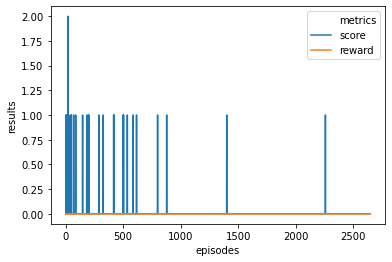

Run time: 600.0655615329742 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [15]:
N0 = 10
gamma = 0.99

# define agent
sarsaAgent = SARSALambdaAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)
sarsaAgent.lambda_value = 1

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=5000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))